<a href="https://colab.research.google.com/github/zyx20180209/2023/blob/main/plant_village.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [2]:
(train, validation, test), info = tfds.load('plant_village', split=['train[:80%]','train[80%:90%]','train[90%:]'], 
                                       with_info=True, as_supervised=True)

In [3]:
# number of classes
classes = info.features['label'].names
num_classes = len(classes)

In [4]:
# resize pictures
height = 256
width = 256
def preprocess(image, label): 
  image2 = tf.image.resize(image, size=(height,width))/255.0 
  label2 = tf.one_hot(label, depth=num_classes) 
  return image2, label2

In [5]:
# preporcess data
train = train.map(preprocess)
validation = validation.map(preprocess)
test = test.map(preprocess)

In [6]:
model = tf.keras.Sequential([     
    tf.keras.Input(shape=(height,width,3)),
    
    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=3, 
                           strides=1, 
                           padding='same',
                           use_bias=False, 
                           activation=None), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2),
                                 strides=2,
                                 padding="valid"),    
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(filters=32, 
                           kernel_size=3, 
                           strides=1, 
                           padding='same',
                           use_bias=False, 
                           activation=None), 
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D((2, 2),
                                 strides=2,
                                 padding="valid"),    
    tf.keras.layers.Dropout(0.2),
                               
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=None),
    tf.keras.layers.BatchNormalization(),  
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')
]) 

In [7]:
model.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

In [8]:
# data augmentation
import random
def data_aug(image, label): 
  x = random.randint(0,1)
  if x == 0:
    image2 = tf.image.flip_up_down(image)
  else: 
    image2 = tf.image.adjust_contrast(image, 1.5)
  return image2, label 

train_aug = train.map(data_aug) 
train_large = train.concatenate(train_aug) 

In [9]:
train_temp= train_large.shuffle(buffer_size=1000, seed=99, reshuffle_each_iteration=
True)
train_batched = train_temp.batch(batch_size= 32)

In [10]:
validation_batched = validation.batch(batch_size = 32)

In [11]:
num_epoch = 5

In [12]:
history = model.fit(train_batched, validation_data=validation_batched , epochs=num_epoch, verbose = 1)

Epoch 1/5
2716/2716 [==============================] - 359s 128ms/step - loss: 0.5488 - accuracy: 0.8412 - val_loss: 1.1244 - val_accuracy: 0.6978
Epoch 2/5
2716/2716 [==============================] - 348s 128ms/step - loss: 0.2114 - accuracy: 0.9336 - val_loss: 0.8864 - val_accuracy: 0.7584
Epoch 3/5
2716/2716 [==============================] - 346s 127ms/step - loss: 0.1138 - accuracy: 0.9639 - val_loss: 1.0713 - val_accuracy: 0.7177
Epoch 4/5
2716/2716 [==============================] - 344s 127ms/step - loss: 0.0711 - accuracy: 0.9775 - val_loss: 0.9999 - val_accuracy: 0.7595
Epoch 5/5
2716/2716 [==============================] - 343s 126ms/step - loss: 0.0541 - accuracy: 0.9829 - val_loss: 0.7370 - val_accuracy: 0.8131


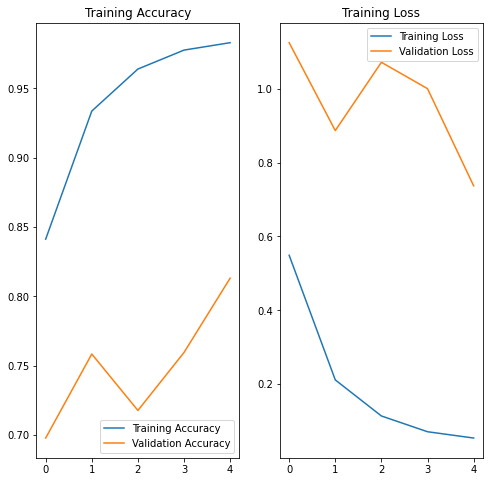

In [13]:
# plot accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epoch)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [16]:
test_batched = test.batch(batch_size= 32)

In [17]:
# accuracy on test dataset
model.evaluate(test_batched)

170/170 [==============================] - 6s 32ms/step - loss: 0.7176 - accuracy: 0.8171


[0.7176195979118347, 0.8171270489692688]

In [18]:
temp = test.take(1).batch(batch_size = 1)
result = model.predict(temp)
n = np.argmax(result)
classes[n]

1/1 [==============================] - 0s 277ms/step


'Apple___healthy'

In [19]:
def make_prediction(image_name):
  img = tf.io.read_file(image_name)
  # convert to tensor 
  tensor = tf.io.decode_image(img, channels=3, dtype=tf.dtypes.float32)
  # resize tensor to fit the input shape of model
  tensor = tf.image.resize(tensor, size=(height,width))
  plt.imshow(tensor)
  # add another dimension at the front to get NHWC shape
  input_tensor = tf.expand_dims(tensor, axis=0)
  predicted = model.predict(input_tensor)
  n = np.argmax(predicted)
  return classes[n]

predict on some pictures from internet 

1/1 [==============================] - 0s 113ms/step


'Blueberry___healthy'

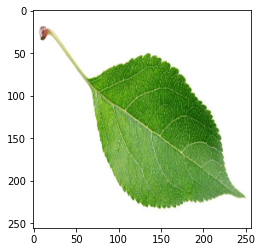

In [20]:
make_prediction("apple_leaf.jpg")

1/1 [==============================] - 0s 44ms/step


'Soybean___healthy'

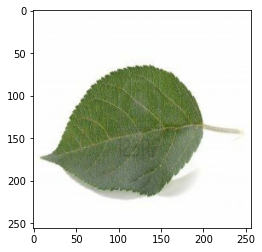

In [21]:
make_prediction("apple_leaf2.jpg")

1/1 [==============================] - 0s 20ms/step


'Blueberry___healthy'

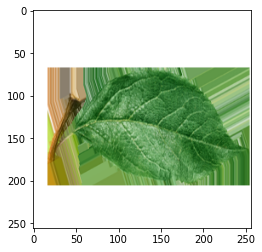

In [22]:
make_prediction("apple_leaf3.png")

1/1 [==============================] - 0s 20ms/step


'Blueberry___healthy'

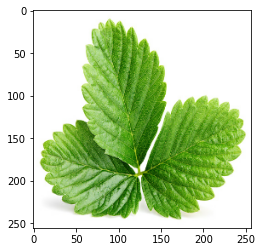

In [23]:
make_prediction("strawberry_leaf1.jpg")

1/1 [==============================] - 0s 21ms/step


'Blueberry___healthy'

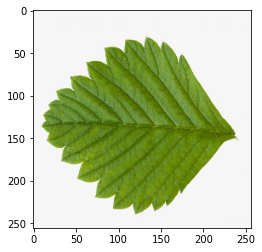

In [24]:
make_prediction("strawberry_leaf2.png")